# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.23KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

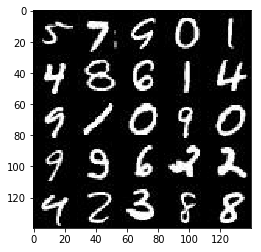

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

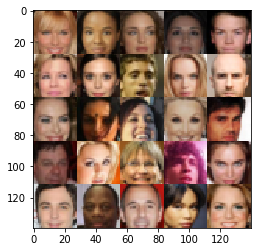

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2 # As shown in the 'DCGAN' IPython notebook

        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits

# n_units = 128 # As shown in the 'Intro-to-GANs' IPython notebook
#         # Add hidden layer
#         h1 = tf.layers.dense(images, n_units, activation=None)
#         # Add leaky ReLu
#         h1 = tf.maximum(alpha * h1, h1)
        
#         logits = tf.layers.dense(h1, 1, activation=None)
#         out = tf.sigmoid(logits)
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    if is_train == True:
        reuse = False
    else:
        reuse = True
    
    with tf.variable_scope('generator', reuse=reuse):
        alpha = 0.2
        # First FC layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape to start CNN stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides = 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now

        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides = 2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                               labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels=tf.ones_like(d_model_fake)))
    
    # NB: g_loss is driven entirely by how well the discriminator's logits
    # from fake data aligns to all label 1s. Antagonistically, the d_loss is driven
    # by the ability of the discriminator to maximize alignment of real data
    # to label 1s and fake data to label 0s. The end of the 2-player game is
    # reached as they approach Nash equilibrium, which is when the discriminator
    # simply outputs ~1/2 for both real and fake data.
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    training_variables = tf.trainable_variables()
    d_vars = [var for var in training_variables if var.name.startswith('discriminator')]
    g_vars = [var for var in training_variables if var.name.startswith('generator')]
    
    # Begin optimization
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [78]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     tf.reset_default_graph()
    
    # Define data parameters
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    out_channel_dim = image_channels
    
    # Collect tf input placeholders
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Calculate losses
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    # Setup optimization schema
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Prepare for training
    saver = tf.train.Saver()
    
    losses = []
    steps = 0
    print_every = 25
    show_every = 100
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2.0 # Transform range to [-1, 1]; this one line was added with outside help
                
                # Sample noise for generator
                batch_z = np.random.uniform(-1,1, size = (batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict = {input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    
                    show_generator_output(sess, 
                                          n_images, 
                                          input_z,
                                          out_channel_dim, 
                                          data_image_mode)

#         saver.save(sess, './checkpoints/generator.ckpt')
        
#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
        
    return losses      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.9338 Generator Loss: 0.0116
Epoch 1/2... Discriminator Loss: 1.8301 Generator Loss: 0.5173
Epoch 1/2... Discriminator Loss: 1.7213 Generator Loss: 1.2672
Epoch 1/2... Discriminator Loss: 1.6590 Generator Loss: 0.3116


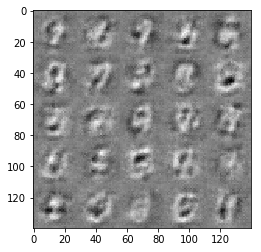

Epoch 1/2... Discriminator Loss: 1.4883 Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 1.5016 Generator Loss: 0.3483
Epoch 1/2... Discriminator Loss: 1.3150 Generator Loss: 1.1590
Epoch 1/2... Discriminator Loss: 1.3944 Generator Loss: 0.3773


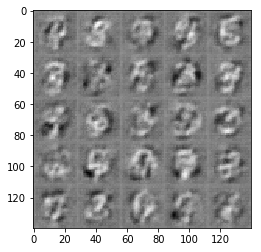

Epoch 1/2... Discriminator Loss: 1.2869 Generator Loss: 1.1037
Epoch 1/2... Discriminator Loss: 1.4000 Generator Loss: 0.3812
Epoch 1/2... Discriminator Loss: 1.1580 Generator Loss: 1.0026
Epoch 1/2... Discriminator Loss: 1.2004 Generator Loss: 0.8458


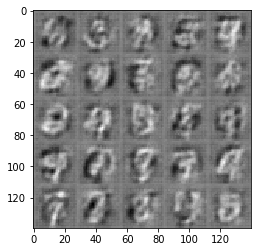

Epoch 1/2... Discriminator Loss: 1.1177 Generator Loss: 0.9548
Epoch 1/2... Discriminator Loss: 0.9513 Generator Loss: 1.1427
Epoch 1/2... Discriminator Loss: 1.0512 Generator Loss: 0.7102
Epoch 1/2... Discriminator Loss: 1.2264 Generator Loss: 1.1929


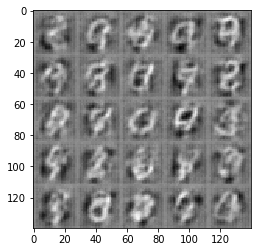

Epoch 1/2... Discriminator Loss: 0.9553 Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 1.1136 Generator Loss: 1.5092
Epoch 1/2... Discriminator Loss: 1.3973 Generator Loss: 1.4905
Epoch 1/2... Discriminator Loss: 1.1869 Generator Loss: 1.5953


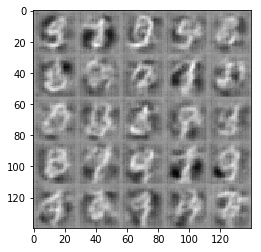

Epoch 1/2... Discriminator Loss: 1.1612 Generator Loss: 0.9594
Epoch 1/2... Discriminator Loss: 1.2043 Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 1.5558 Generator Loss: 0.3436
Epoch 1/2... Discriminator Loss: 1.5936 Generator Loss: 1.3989


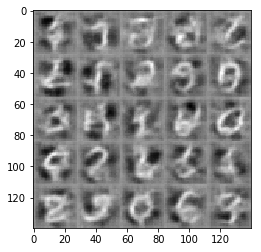

Epoch 1/2... Discriminator Loss: 1.2747 Generator Loss: 0.5175
Epoch 1/2... Discriminator Loss: 1.4446 Generator Loss: 1.3172
Epoch 1/2... Discriminator Loss: 1.2402 Generator Loss: 0.6435
Epoch 1/2... Discriminator Loss: 1.6098 Generator Loss: 0.3202


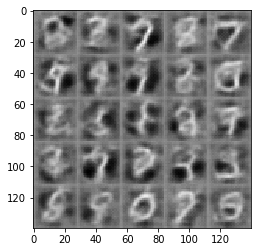

Epoch 1/2... Discriminator Loss: 1.4202 Generator Loss: 1.2239
Epoch 1/2... Discriminator Loss: 1.2970 Generator Loss: 0.5058
Epoch 1/2... Discriminator Loss: 1.2865 Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.4265 Generator Loss: 0.4258


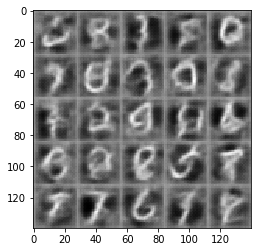

Epoch 1/2... Discriminator Loss: 1.3457 Generator Loss: 1.0059
Epoch 1/2... Discriminator Loss: 1.2421 Generator Loss: 0.6209
Epoch 1/2... Discriminator Loss: 1.2381 Generator Loss: 0.5525
Epoch 1/2... Discriminator Loss: 1.1471 Generator Loss: 0.7394


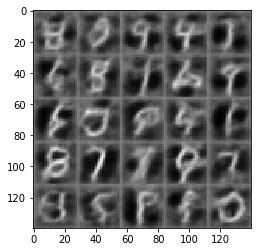

Epoch 1/2... Discriminator Loss: 1.6981 Generator Loss: 1.7538
Epoch 1/2... Discriminator Loss: 1.1959 Generator Loss: 0.5663
Epoch 1/2... Discriminator Loss: 1.2241 Generator Loss: 0.5956
Epoch 1/2... Discriminator Loss: 1.2363 Generator Loss: 1.1911


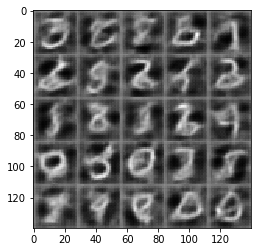

Epoch 1/2... Discriminator Loss: 1.3183 Generator Loss: 0.4468
Epoch 1/2... Discriminator Loss: 1.2370 Generator Loss: 0.5065
Epoch 1/2... Discriminator Loss: 1.0878 Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 1.0909 Generator Loss: 0.9779


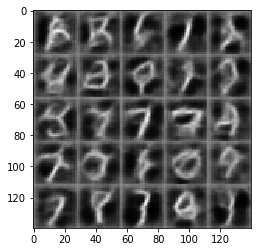

Epoch 1/2... Discriminator Loss: 1.0577 Generator Loss: 1.1735
Epoch 1/2... Discriminator Loss: 1.2881 Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 1.3112 Generator Loss: 0.7397
Epoch 1/2... Discriminator Loss: 1.2455 Generator Loss: 0.4860


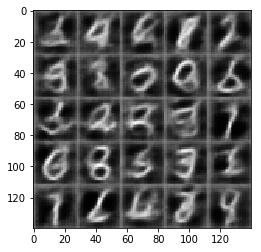

Epoch 1/2... Discriminator Loss: 1.3551 Generator Loss: 0.5082
Epoch 1/2... Discriminator Loss: 1.1789 Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 1.0407 Generator Loss: 1.0230
Epoch 1/2... Discriminator Loss: 1.5966 Generator Loss: 0.2960


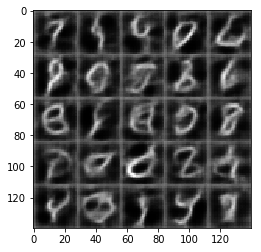

Epoch 1/2... Discriminator Loss: 1.3193 Generator Loss: 0.4802
Epoch 1/2... Discriminator Loss: 1.1071 Generator Loss: 0.5932
Epoch 1/2... Discriminator Loss: 1.0680 Generator Loss: 0.7161
Epoch 1/2... Discriminator Loss: 1.1393 Generator Loss: 0.5591


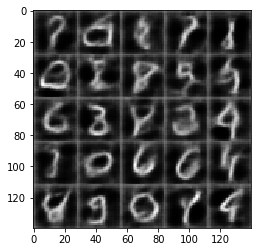

Epoch 1/2... Discriminator Loss: 1.2778 Generator Loss: 0.5264
Epoch 1/2... Discriminator Loss: 1.0237 Generator Loss: 1.2809
Epoch 1/2... Discriminator Loss: 1.0511 Generator Loss: 0.7057
Epoch 1/2... Discriminator Loss: 1.5624 Generator Loss: 0.3312


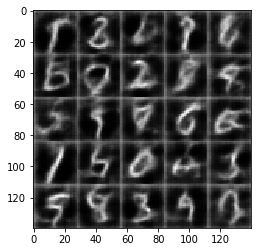

Epoch 1/2... Discriminator Loss: 1.1315 Generator Loss: 1.0477
Epoch 1/2... Discriminator Loss: 1.1100 Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 1.1623 Generator Loss: 0.5454
Epoch 1/2... Discriminator Loss: 1.3306 Generator Loss: 1.1828


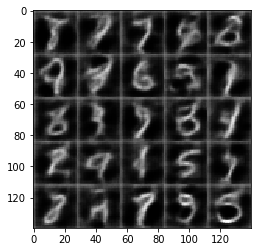

Epoch 1/2... Discriminator Loss: 1.0417 Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 1.2443 Generator Loss: 0.6714
Epoch 1/2... Discriminator Loss: 0.9530 Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.1455 Generator Loss: 0.6735


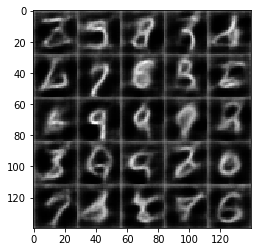

Epoch 1/2... Discriminator Loss: 1.2714 Generator Loss: 0.4659
Epoch 1/2... Discriminator Loss: 1.5508 Generator Loss: 0.3247
Epoch 1/2... Discriminator Loss: 1.3691 Generator Loss: 0.3667
Epoch 1/2... Discriminator Loss: 0.9574 Generator Loss: 0.9115


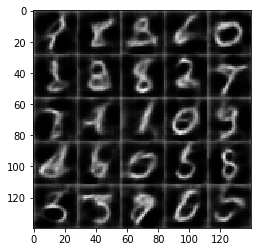

Epoch 1/2... Discriminator Loss: 1.1309 Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 0.9898 Generator Loss: 0.7899
Epoch 1/2... Discriminator Loss: 0.9239 Generator Loss: 1.0072
Epoch 2/2... Discriminator Loss: 1.3200 Generator Loss: 0.4087


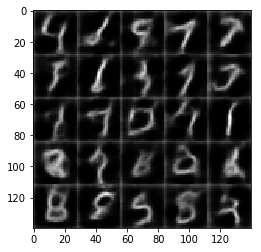

Epoch 2/2... Discriminator Loss: 1.3401 Generator Loss: 0.4191
Epoch 2/2... Discriminator Loss: 1.1702 Generator Loss: 0.6267
Epoch 2/2... Discriminator Loss: 1.8279 Generator Loss: 0.2251
Epoch 2/2... Discriminator Loss: 0.9370 Generator Loss: 0.7479


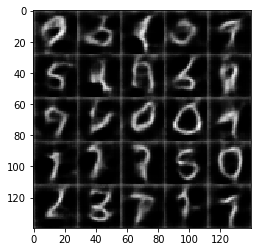

Epoch 2/2... Discriminator Loss: 0.8949 Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 0.9945 Generator Loss: 1.1173
Epoch 2/2... Discriminator Loss: 1.0716 Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 1.3849 Generator Loss: 0.4119


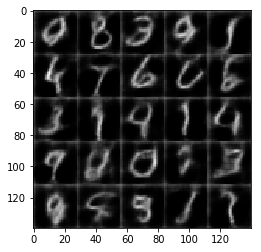

Epoch 2/2... Discriminator Loss: 0.7842 Generator Loss: 1.2506
Epoch 2/2... Discriminator Loss: 0.9833 Generator Loss: 1.2401
Epoch 2/2... Discriminator Loss: 1.1748 Generator Loss: 0.4744
Epoch 2/2... Discriminator Loss: 1.2910 Generator Loss: 0.4984


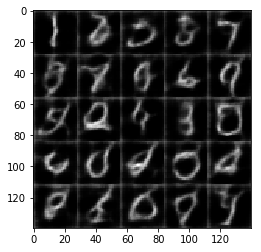

Epoch 2/2... Discriminator Loss: 0.8821 Generator Loss: 1.1196
Epoch 2/2... Discriminator Loss: 0.8805 Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 0.9628 Generator Loss: 1.2027
Epoch 2/2... Discriminator Loss: 0.8911 Generator Loss: 1.2630


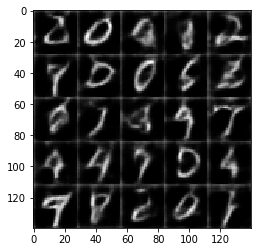

Epoch 2/2... Discriminator Loss: 1.1465 Generator Loss: 0.5120
Epoch 2/2... Discriminator Loss: 1.0429 Generator Loss: 0.7311
Epoch 2/2... Discriminator Loss: 1.1434 Generator Loss: 1.3604
Epoch 2/2... Discriminator Loss: 0.8933 Generator Loss: 1.5603


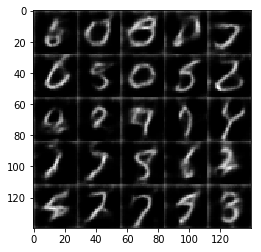

Epoch 2/2... Discriminator Loss: 1.4363 Generator Loss: 0.3460
Epoch 2/2... Discriminator Loss: 1.5856 Generator Loss: 0.2957
Epoch 2/2... Discriminator Loss: 1.2551 Generator Loss: 0.4645
Epoch 2/2... Discriminator Loss: 1.2691 Generator Loss: 0.4349


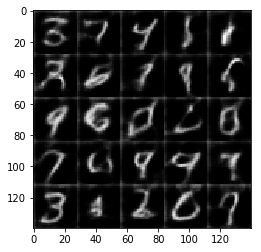

Epoch 2/2... Discriminator Loss: 0.8310 Generator Loss: 1.0285
Epoch 2/2... Discriminator Loss: 1.4104 Generator Loss: 0.3755
Epoch 2/2... Discriminator Loss: 1.1115 Generator Loss: 0.5706
Epoch 2/2... Discriminator Loss: 1.1451 Generator Loss: 0.5070


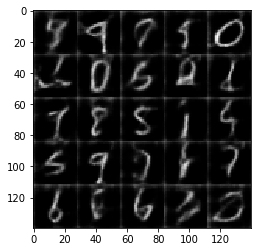

Epoch 2/2... Discriminator Loss: 1.2698 Generator Loss: 1.9583
Epoch 2/2... Discriminator Loss: 0.9403 Generator Loss: 1.1040
Epoch 2/2... Discriminator Loss: 1.9452 Generator Loss: 0.2068
Epoch 2/2... Discriminator Loss: 1.1226 Generator Loss: 0.5249


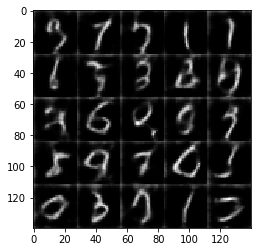

Epoch 2/2... Discriminator Loss: 0.8976 Generator Loss: 1.0685
Epoch 2/2... Discriminator Loss: 0.9283 Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 0.9424 Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 0.9648 Generator Loss: 1.1859


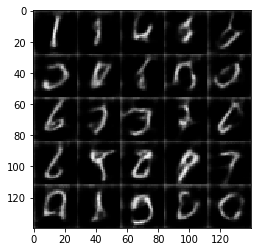

Epoch 2/2... Discriminator Loss: 0.9576 Generator Loss: 0.8726
Epoch 2/2... Discriminator Loss: 0.8437 Generator Loss: 1.1003
Epoch 2/2... Discriminator Loss: 0.8899 Generator Loss: 0.9811
Epoch 2/2... Discriminator Loss: 0.8790 Generator Loss: 1.0349


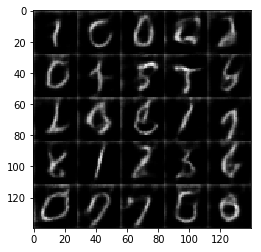

Epoch 2/2... Discriminator Loss: 0.9050 Generator Loss: 0.7356
Epoch 2/2... Discriminator Loss: 0.7461 Generator Loss: 1.2076
Epoch 2/2... Discriminator Loss: 1.0797 Generator Loss: 1.4722
Epoch 2/2... Discriminator Loss: 0.7329 Generator Loss: 1.5912


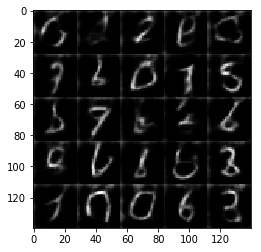

Epoch 2/2... Discriminator Loss: 0.7610 Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 1.2088 Generator Loss: 0.5091
Epoch 2/2... Discriminator Loss: 1.1851 Generator Loss: 0.4711
Epoch 2/2... Discriminator Loss: 1.3760 Generator Loss: 0.3581


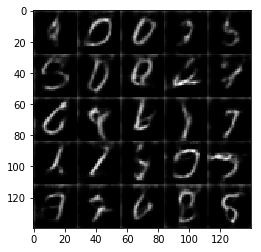

Epoch 2/2... Discriminator Loss: 0.9593 Generator Loss: 0.9130
Epoch 2/2... Discriminator Loss: 1.2976 Generator Loss: 0.4732
Epoch 2/2... Discriminator Loss: 1.4347 Generator Loss: 0.3593
Epoch 2/2... Discriminator Loss: 0.8463 Generator Loss: 1.0388


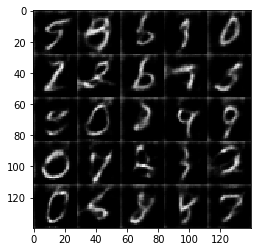

Epoch 2/2... Discriminator Loss: 0.7599 Generator Loss: 1.0963
Epoch 2/2... Discriminator Loss: 1.0264 Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 1.3951 Generator Loss: 0.3724
Epoch 2/2... Discriminator Loss: 0.8678 Generator Loss: 0.9672


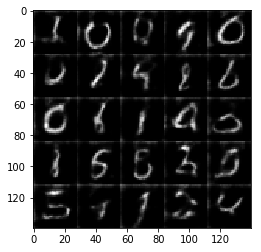

Epoch 2/2... Discriminator Loss: 0.8018 Generator Loss: 0.9159
Epoch 2/2... Discriminator Loss: 1.2981 Generator Loss: 0.4211
Epoch 2/2... Discriminator Loss: 1.1612 Generator Loss: 0.4934
Epoch 2/2... Discriminator Loss: 1.0840 Generator Loss: 2.0093


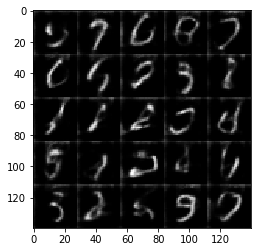

Epoch 2/2... Discriminator Loss: 0.6205 Generator Loss: 1.1891
Epoch 2/2... Discriminator Loss: 0.9030 Generator Loss: 1.6993
Epoch 2/2... Discriminator Loss: 1.1929 Generator Loss: 0.4856
Epoch 2/2... Discriminator Loss: 1.1231 Generator Loss: 0.5140


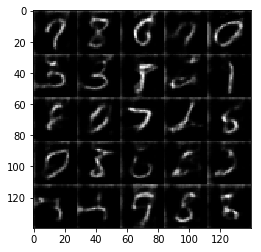

Epoch 2/2... Discriminator Loss: 0.7993 Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 1.2409 Generator Loss: 0.4525
Epoch 2/2... Discriminator Loss: 0.6410 Generator Loss: 1.4364
Epoch 2/2... Discriminator Loss: 1.1378 Generator Loss: 0.5481


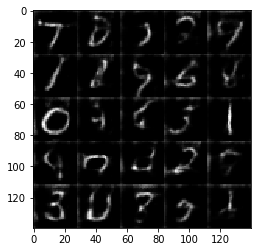

Epoch 2/2... Discriminator Loss: 2.4426 Generator Loss: 0.1132
Epoch 2/2... Discriminator Loss: 1.1295 Generator Loss: 0.5050
Epoch 2/2... Discriminator Loss: 0.7283 Generator Loss: 0.8481
Epoch 2/2... Discriminator Loss: 0.9414 Generator Loss: 1.5440


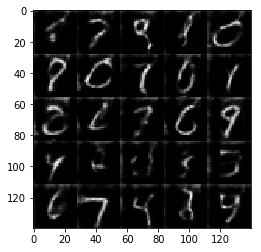

Epoch 2/2... Discriminator Loss: 0.8733 Generator Loss: 0.7245
Epoch 2/2... Discriminator Loss: 1.2507 Generator Loss: 0.4647


In [84]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3685 Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 0.6687 Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 1.6189 Generator Loss: 0.3313
Epoch 1/1... Discriminator Loss: 1.3668 Generator Loss: 1.6541


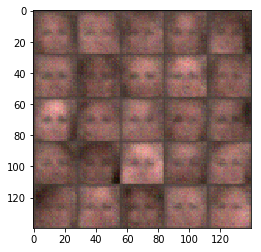

Epoch 1/1... Discriminator Loss: 1.5048 Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.3782 Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.5819 Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 2.1796 Generator Loss: 0.1499


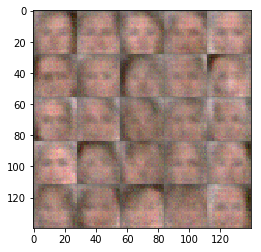

Epoch 1/1... Discriminator Loss: 0.9797 Generator Loss: 2.2329
Epoch 1/1... Discriminator Loss: 1.4444 Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 0.7033 Generator Loss: 2.1000
Epoch 1/1... Discriminator Loss: 0.7429 Generator Loss: 1.6780


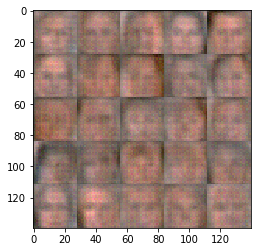

Epoch 1/1... Discriminator Loss: 1.2157 Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 0.9779 Generator Loss: 1.8069
Epoch 1/1... Discriminator Loss: 0.8396 Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.3484 Generator Loss: 1.5978


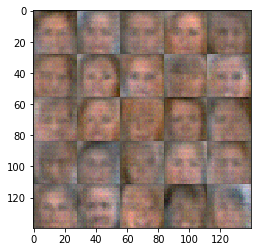

Epoch 1/1... Discriminator Loss: 1.0025 Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 0.9041 Generator Loss: 2.5193
Epoch 1/1... Discriminator Loss: 1.4276 Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 1.2957 Generator Loss: 1.5596


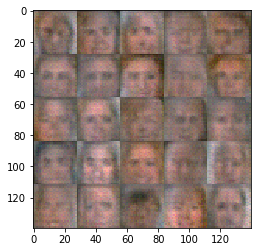

Epoch 1/1... Discriminator Loss: 1.1789 Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 0.9587 Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 1.5223 Generator Loss: 2.4601
Epoch 1/1... Discriminator Loss: 1.9219 Generator Loss: 0.1954


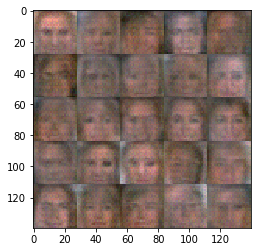

Epoch 1/1... Discriminator Loss: 1.3010 Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.4530 Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 1.6451 Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.5850 Generator Loss: 1.3792


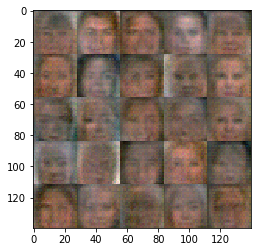

Epoch 1/1... Discriminator Loss: 1.5823 Generator Loss: 0.3385
Epoch 1/1... Discriminator Loss: 0.8195 Generator Loss: 1.6500
Epoch 1/1... Discriminator Loss: 1.3192 Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 1.4804 Generator Loss: 0.6863


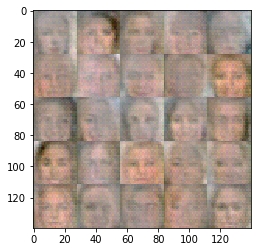

Epoch 1/1... Discriminator Loss: 1.0602 Generator Loss: 2.2723
Epoch 1/1... Discriminator Loss: 0.7945 Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 0.7467 Generator Loss: 2.8479
Epoch 1/1... Discriminator Loss: 1.3375 Generator Loss: 0.4602


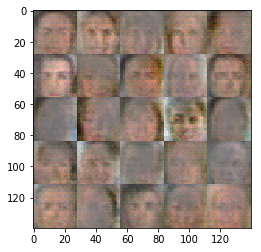

Epoch 1/1... Discriminator Loss: 1.1770 Generator Loss: 1.4539
Epoch 1/1... Discriminator Loss: 1.6742 Generator Loss: 0.3188
Epoch 1/1... Discriminator Loss: 0.5377 Generator Loss: 1.8718
Epoch 1/1... Discriminator Loss: 1.6279 Generator Loss: 0.3442


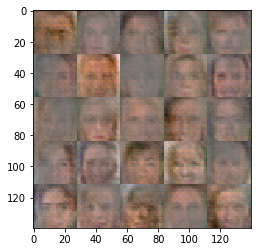

Epoch 1/1... Discriminator Loss: 0.9079 Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.1571 Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 0.9305 Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 1.4666 Generator Loss: 0.3449


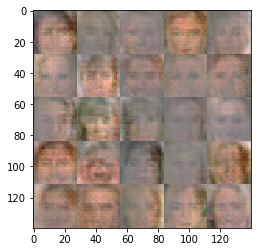

Epoch 1/1... Discriminator Loss: 1.4062 Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.1863 Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.0777 Generator Loss: 1.4206
Epoch 1/1... Discriminator Loss: 1.2168 Generator Loss: 0.4991


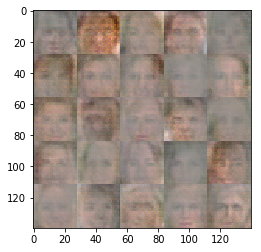

Epoch 1/1... Discriminator Loss: 0.9519 Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 1.5810 Generator Loss: 0.3108
Epoch 1/1... Discriminator Loss: 0.6940 Generator Loss: 2.1202
Epoch 1/1... Discriminator Loss: 1.0899 Generator Loss: 0.5842


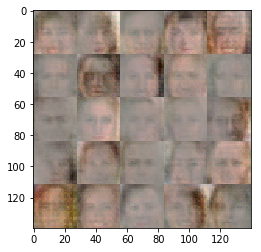

Epoch 1/1... Discriminator Loss: 0.8906 Generator Loss: 2.0781
Epoch 1/1... Discriminator Loss: 1.4408 Generator Loss: 0.3813
Epoch 1/1... Discriminator Loss: 0.7323 Generator Loss: 1.4708


KeyboardInterrupt: 

In [83]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.